In [3]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import necessary libraries
import json
import pandas as pd

# STEP 3: Load the JSON file
json_path = "/content/drive/MyDrive/reviews.json"  # adjust if needed
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# STEP 4: Flatten the nested structure into a DataFrame
flattened_reviews = []

for paper in data['paper']:
    paper_id = paper.get('id')
    preliminary_decision = paper.get('preliminary_decision')

    for review in paper['review']:
        flattened_review = {
            'paper_id': paper_id,
            'preliminary_decision': preliminary_decision,
            'review_id': review.get('id'),
            'confidence': review.get('confidence'),
            'evaluation': review.get('evaluation'),
            'orientation': review.get('orientation'),
            'language': review.get('lan'),
            'remarks': review.get('remarks'),
            'text': review.get('text'),
            'timespan': review.get('timespan')
        }
        flattened_reviews.append(flattened_review)

# STEP 5: Create the DataFrame
df = pd.DataFrame(flattened_reviews)
print("✅ Flattened DataFrame created. Shape:", df.shape)
print(df.head(2))


Mounted at /content/drive
✅ Flattened DataFrame created. Shape: (405, 10)
   paper_id preliminary_decision  review_id confidence evaluation orientation  \
0         1               accept          1          4          1           0   
1         1               accept          2          4          1           1   

  language remarks                                               text  \
0       es          - El artículo aborda un problema contingente y...   
1       es          El artículo presenta recomendaciones prácticas...   

     timespan  
0  2010-07-05  
1  2010-07-05  


In [4]:
print(df.columns)



Index(['paper_id', 'preliminary_decision', 'review_id', 'confidence',
       'evaluation', 'orientation', 'language', 'remarks', 'text', 'timespan'],
      dtype='object')


<Axes: xlabel='preliminary_decision'>

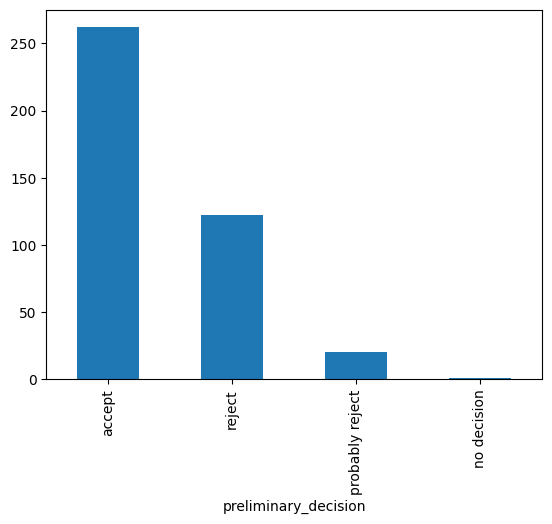

In [5]:
df['preliminary_decision'].value_counts().plot(kind='bar')


In [6]:
df['label'] = df['preliminary_decision'].map({
    'accept': 'positive',
    'reject': 'negative',
    'probably reject': 'negative',
    'no decision': 'neutral'
})


In [34]:
df = df[df['label'].isin(['positive', 'negative'])]


<Axes: xlabel='label'>

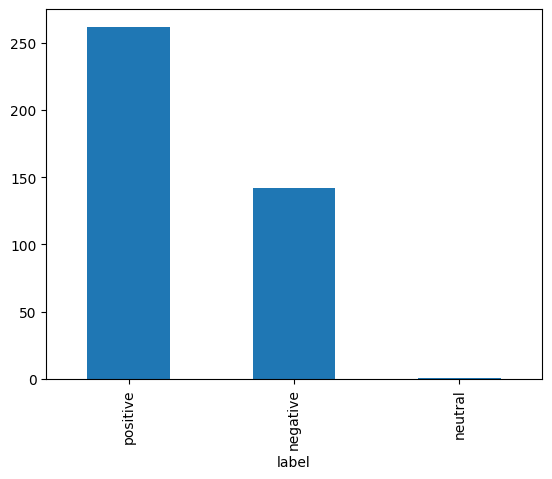

In [7]:
df['label'].value_counts().plot(kind='bar')


In [8]:
from sklearn.utils import resample

# Split
positive_df = df[df['label'] == 'positive']
negative_df = df[df['label'] == 'negative']

# Oversample negative
negative_upsampled = resample(negative_df,
                              replace=True,
                              n_samples=len(positive_df),
                              random_state=42)

# Combine and shuffle
df_balanced = pd.concat([positive_df, negative_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [9]:


import nltk
import os

# Define your custom download dir
nltk_data_path = "/usr/local/nltk_data"
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.clear()
nltk.data.path.append(nltk_data_path)


In [10]:
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)


[nltk_data] Downloading package punkt to /usr/local/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /usr/local/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/local/nltk_data...
[nltk_data] Downloading package omw-1.4 to /usr/local/nltk_data...


True

In [11]:
import os
from nltk.corpus.util import LazyCorpusLoader
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

# Manually load stopwords from the correct location
custom_stopwords_path = "/usr/local/nltk_data/corpora/stopwords"
english_stopwords_file = os.path.join(custom_stopwords_path, "english")

with open(english_stopwords_file, "r") as f:
    stop_words = set(f.read().split())

# ✅ Check if working
print("stopword sample:", list(stop_words)[:10])


stopword sample: ["i'm", "shouldn't", 'ain', 'before', "couldn't", 'couldn', 'hasn', "they'll", 'up', "wouldn't"]


In [12]:
from nltk.stem import WordNetLemmatizer
import re

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()  # 🔁 replaces word_tokenize()
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)





In [13]:
df_balanced['clean_text'] = df_balanced['text'].apply(preprocess_text)


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [15]:
MAX_VOCAB = 10000  # only keep the top 10k most frequent words

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced['clean_text'])

import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)




In [16]:

# MAX_LEN = 200   max sequence length for LSTM


sequences = tokenizer.texts_to_sequences(df_balanced['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=200)


In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_balanced['label'])  # positive = 1, negative = 0 (or vice versa)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

VOCAB_SIZE = 10000
EMBEDDING_DIM = 128

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])




In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train,
                    epochs=6,
                    batch_size=32,
                    validation_data=(X_val, y_val))


Epoch 1/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.5415 - loss: 0.6929 - val_accuracy: 0.5619 - val_loss: 0.6839
Epoch 2/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6254 - loss: 0.6740 - val_accuracy: 0.5619 - val_loss: 0.6728
Epoch 3/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7206 - loss: 0.5930 - val_accuracy: 0.6952 - val_loss: 0.5873
Epoch 4/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8522 - loss: 0.4277 - val_accuracy: 0.6857 - val_loss: 0.6312
Epoch 5/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9534 - loss: 0.2016 - val_accuracy: 0.5905 - val_loss: 2.5732
Epoch 6/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8769 - loss: 0.4885 - val_accuracy: 0.6952 - val_loss: 0.6294


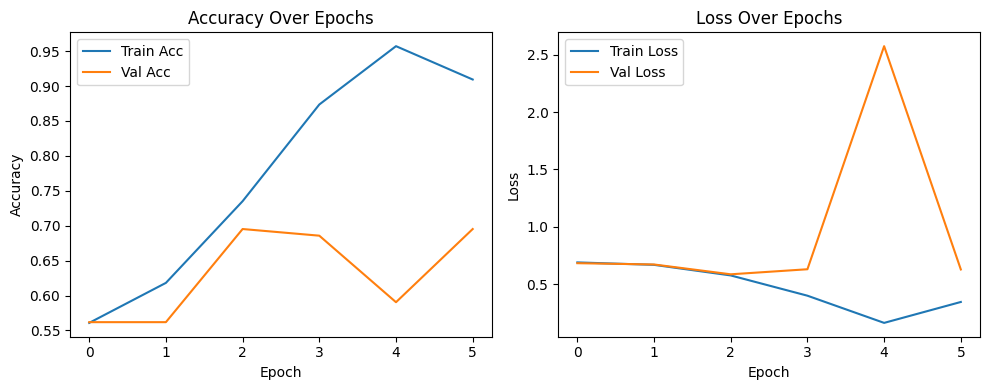

In [21]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import classification_report

# Predict on validation data
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probs to 0/1

# Show classification report
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
              precision    recall  f1-score   support

    negative       0.59      0.96      0.73        46
    positive       0.94      0.49      0.64        59

    accuracy                           0.70       105
   macro avg       0.77      0.72      0.69       105
weighted avg       0.79      0.70      0.68       105



In [23]:
model.save("sentiment_model2.keras")


In [24]:
from tensorflow.keras.models import load_model
model = load_model("sentiment_model2.keras")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


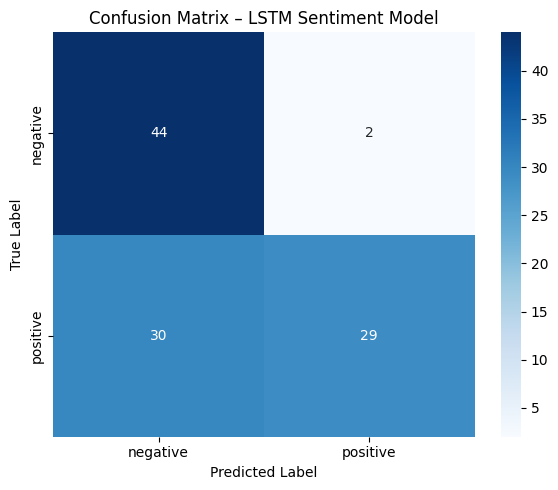

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using your LSTM model
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
class_names = label_encoder.classes_  # ['negative', 'positive']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix – LSTM Sentiment Model')
plt.tight_layout()
plt.show()


In [26]:
from sklearn.model_selection import train_test_split

# Keep track of original indices
indices = df_balanced.index.values
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    padded_sequences, labels, indices, test_size=0.2, random_state=42
)



In [27]:
# Inverse transform labels
true_labels = label_encoder.inverse_transform(y_val)
pred_labels = label_encoder.inverse_transform(y_pred)

# Create results DataFrame
results_df = pd.DataFrame({
    "original_text": df_balanced.loc[idx_val, 'text'].values,
    "clean_text": df_balanced.loc[idx_val, 'clean_text'].values,
    "true_label": true_labels,
    "predicted_label": pred_labels
})

# Save it
results_df.to_csv("lstm_predictions.csv", index=False)


In [28]:
df_preview = pd.read_csv("lstm_predictions.csv")
df_preview.head()


,original_text,clean_text,true_label,predicted_label
0,Un Objeto de Aprendizaje sirve como apoyo al p...,un objeto de aprendizaje sirve como apoyo al p...,negative,negative
1,- El artículo aborda un problema relevante y e...,el artculo aborda un problema relevante en bog...,negative,negative
2,A lo largo del artículo se exagera el rol de l...,lo largo del artculo se exagera el rol de la a...,negative,negative
3,El paper describe el contexto actual del uso d...,el paper describe el contexto actual del uso d...,positive,negative
4,this paper applies an advanced algorithm to ga...,paper applies advanced algorithm gait control ...,positive,positive


In [29]:
from google.colab import files
files.download("lstm_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>